In [169]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torchinfo
import torchtext.transforms as T
from torch.utils.data import DataLoader
from torchlake.common.controller.evaluator import ClassificationEvaluator
from torchlake.common.schemas import NlpContext
from torchlake.common.utils.platform import get_file_size, get_num_workers
from torchlake.common.utils.text import build_vocab
from torchlake.tag_prediction.controllers.trainer_bilstm_crf import BiLSTMCRFTrainer
from torchlake.tag_prediction.models.bilstm_crf import (BiLSTMCRF,
                                                        LinearCRFLoss)
from torchtext.data.utils import get_tokenizer
from torchtext.datasets import CoNLL2000Chunking

# setting


In [170]:
artifacts_path = Path("../../artifacts/bilstm-crf")
data_path = Path("../../data/CoNLL2000")

In [171]:
BATCH_SIZE = 128
CONTEXT = NlpContext()

# data


In [172]:
def datapipe_factory(datapipe, text_transform=None, label_transform=None):
    datapipe = datapipe.map(
        lambda pair: [[word.lower() for word in pair[0]], pair[1]]
    ).filter(lambda item: len(item[0]) > CONTEXT.min_seq_len)

    if text_transform:
        datapipe = datapipe.map(lambda item: (text_transform(item[0]), item[1]))

    if label_transform:
        datapipe = datapipe.map(lambda item: (item[0], label_transform(item[1])))

    return datapipe

In [173]:
train_data, test_data = CoNLL2000Chunking(data_path.as_posix())

In [174]:
vocab = build_vocab(map(lambda it: it[0], train_data))
label_vocab = build_vocab(map(lambda it: it[1], train_data))

In [175]:
VOCAB_SIZE = len(vocab)
NUM_CLASS = len(label_vocab)

In [176]:
VOCAB_SIZE, NUM_CLASS

(4406, 48)

In [177]:
text_transform = T.Sequential(
    T.VocabTransform(vocab),
    T.Truncate(CONTEXT.max_seq_len - 2),
    T.AddToken(token=CONTEXT.bos_idx, begin=True),
    T.AddToken(token=CONTEXT.eos_idx, begin=False),
    T.ToTensor(),
    T.PadTransform(CONTEXT.max_seq_len, CONTEXT.padding_idx),
)

In [178]:
label_transform = T.Sequential(
    T.VocabTransform(label_vocab),
    T.Truncate(CONTEXT.max_seq_len - 2),
    T.AddToken(token=CONTEXT.bos_idx, begin=True),
    T.AddToken(token=CONTEXT.eos_idx, begin=False),
    T.ToTensor(),
    T.PadTransform(CONTEXT.max_seq_len, CONTEXT.padding_idx),
)

In [179]:
def collate_fn(batch: list):
    text_placeholder, label_placeholder = [], []

    for row in batch:
        text, label = row[0], row[1]
        text_placeholder.append(text)
        label_placeholder.append(label)

    return torch.stack(text_placeholder), torch.stack(label_placeholder)

In [180]:
NUM_WORKERS = get_num_workers()

In [181]:
train_iter = DataLoader(
    datapipe_factory(train_data, text_transform, label_transform),
    batch_size=BATCH_SIZE,
    # collate_fn=collate_fn,
    num_workers=NUM_WORKERS,
    shuffle=True,
    drop_last=True,
)

test_iter = DataLoader(
    datapipe_factory(test_data, text_transform, label_transform),
    batch_size=BATCH_SIZE,
    # collate_fn=collate_fn,
    num_workers=NUM_WORKERS,
)

d:\research\pytorch-implementations\.venv\Lib\site-packages\torch\utils\data\datapipes\utils\common.py:141: UserWarning: Local function is not supported by pickle, please use regular python function or functools.partial instead.
  warnings.warn(


In [182]:
for text, label in train_iter:
    print(text.shape, label.shape)
    break

torch.Size([128, 256]) torch.Size([128, 256])


# model


In [183]:
DEVICE = torch.device(CONTEXT.device)

In [184]:
EMBED_DIM = 300
HIDDEN_DIM = 256
model = BiLSTMCRF(
    VOCAB_SIZE,
    EMBED_DIM,
    HIDDEN_DIM,
    NUM_CLASS,
    num_layers=2,
    context=CONTEXT,
).to(DEVICE)

In [185]:
torchinfo.summary(model)

Layer (type:depth-idx)                   Param #
BiLSTMCRF                                --
├─LSTMDiscriminator: 1-1                 --
│    └─Embedding: 2-1                    1,321,800
│    └─LSTM: 2-2                         2,719,744
│    └─LayerNorm: 2-3                    1,024
│    └─Linear: 2-4                       24,624
├─LinearCRF: 1-2                         2,304
Total params: 4,069,496
Trainable params: 4,069,496
Non-trainable params: 0

# train


In [186]:
EPOCHES = 30

In [187]:
trainer = BiLSTMCRFTrainer(EPOCHES, DEVICE)

In [188]:
criterion = LinearCRFLoss(crf_weight=10, context=CONTEXT)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, weight_decay=1e-4)

In [189]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, threshold=.05 ,threshold_mode ='rel')

In [190]:
training_loss = trainer.run(train_iter, model, optimizer, criterion, scheduler)

67it [00:06, 10.05it/s]


epoch 1 : 16.7716871695732


67it [00:05, 12.17it/s]


epoch 2 : 3.514554607334422


67it [00:05, 12.25it/s]


epoch 3 : 3.100198464607125


67it [00:05, 11.44it/s]


epoch 4 : 2.7613431055154374


67it [00:05, 12.35it/s]


epoch 5 : 2.5503544273661145


67it [00:05, 12.32it/s]


epoch 6 : 2.367295809646151


67it [00:05, 12.36it/s]


epoch 7 : 2.231012027655075


67it [00:05, 12.00it/s]


epoch 8 : 2.1144108825655126


67it [00:05, 12.34it/s]


epoch 9 : 2.03115618584761


67it [00:05, 12.34it/s]


epoch 10 : 1.9473694242648225


67it [00:05, 12.31it/s]


epoch 11 : 1.8791448233732537


67it [00:05, 12.00it/s]


epoch 12 : 1.8056974606727487


67it [00:05, 12.18it/s]


epoch 13 : 1.75312253788336


67it [00:05, 12.17it/s]


epoch 14 : 1.6926954895702762


67it [00:05, 12.27it/s]


epoch 15 : 1.6869242582748185


67it [00:05, 11.99it/s]


epoch 16 : 1.6412668637375334


67it [00:05, 12.31it/s]


epoch 17 : 1.6165546819345276


67it [00:05, 12.30it/s]


epoch 18 : 1.5900407869424393


67it [00:05, 12.32it/s]


epoch 19 : 1.5888278288627737


67it [00:05, 12.06it/s]


epoch 20 : 1.5793213417280967


67it [00:05, 12.32it/s]


epoch 21 : 1.5687427129318465


67it [00:05, 12.35it/s]


epoch 22 : 1.558733860058571


67it [00:05, 12.36it/s]


epoch 23 : 1.5743316767820672


67it [00:05, 12.04it/s]


epoch 24 : 1.5609386572197301


67it [00:05, 12.35it/s]


epoch 25 : 1.5903305811668509


67it [00:05, 12.35it/s]


epoch 26 : 1.5885328641578333


67it [00:05, 11.96it/s]


epoch 27 : 1.5836782722330804


67it [00:05, 12.37it/s]


epoch 28 : 1.5792897067852874


67it [00:05, 12.41it/s]


epoch 29 : 1.5736045339214269


67it [00:05, 12.34it/s]

epoch 30 : 1.5694690177689736


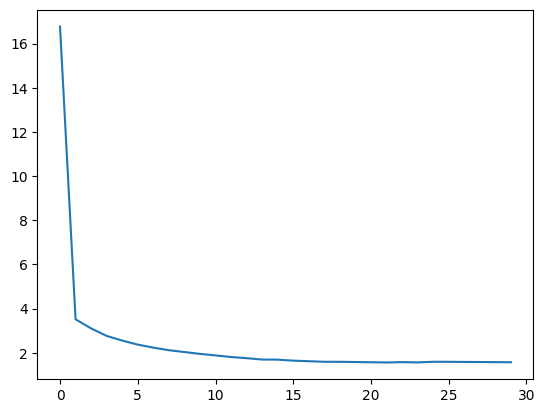

In [191]:
plt.plot(training_loss)

# inference


In [192]:
evaluator = ClassificationEvaluator(NUM_CLASS, DEVICE, feature_dim=-1) # for crf, need to set reduction=None

In [193]:
confusion_matrix = evaluator.run(test_iter, model.foot) # for bilstm itself, use model.foot, otherwise use model

16it [00:01, 14.48it/s]

[[   0    0    0 ...    0    0    0]
 [   0 1949    0 ...    0    0    0]
 [   0    0 1949 ...    0    0    0]
 ...
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    0]]


In [194]:
per_class_acc = evaluator.get_per_class_accuracy(confusion_matrix)
evaluator.show_per_class_accuracy(label_vocab.get_itos(), per_class_acc)

<unk>     : 0.0
<bos>     : 1.0
<eos>     : 1.0
<pad>     : 0.0
NN        : 0.6312005751258087
IN        : 0.974258533855624
NNP       : 0.6179104477611941
DT        : 0.9848308051341891
NNS       : 0.6326009197751661
JJ        : 0.6393022062596203
,         : 1.0
.         : 0.9984488107549121
CD        : 0.7912568306010929
VBD       : 0.8314350797266514
RB        : 0.7575169738118331
VB        : 0.8407908428720083
CC        : 0.9889380530973452
TO        : 1.0
VBN       : 0.6747368421052632
VBZ       : 0.7857142857142857
PRP       : 0.9504950495049505
VBG       : 0.5623145400593472
VBP       : 0.7606837606837606
MD        : 1.0
PRP$      : 1.0
POS       : 0.9973958333333334
$         : 0.9885496183206107
``        : 1.0
''        : 0.9897959183673469
:         : 0.9936305732484076
WDT       : 0.7927461139896373
JJR       : 0.8064516129032258
WP        : 0.9519230769230769
WRB       : 0.9887640449438202
NNPS      : 0.008403361344537815
JJS       : 0.8266666666666667
RBR       : 0.4285

In [195]:
per_class_acc[4:].mean()

0.6649604085346176

d:\research\pytorch-implementations\.venv\Lib\site-packages\torchlake\common\controller\evaluator.py:129: RuntimeWarning: invalid value encountered in divide
  percentage = np.where(total == 0, 0, hits / total)


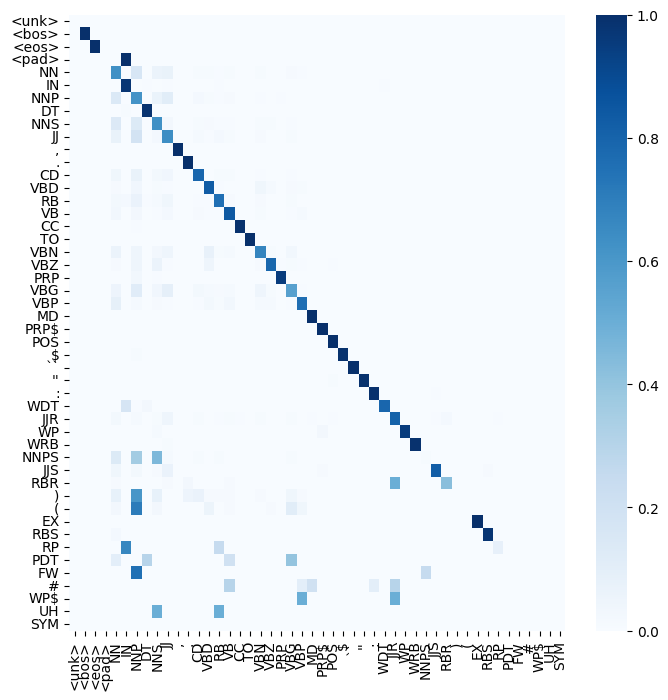

In [196]:
evaluator.plot_confusion_matrix(
    confusion_matrix,
    label_vocab.get_itos(),
    "Blues",
    annot=False,
    figsize=(8, 8),
)

In [197]:
model_path = artifacts_path / 'conll2000.pth'

In [198]:
torch.save(model.state_dict(), model_path.as_posix())

In [199]:
get_file_size(model_path)

'15.53MiB'

In [200]:
model.load_state_dict(torch.load(model_path.as_posix()))

<All keys matched successfully>

# Visualization


In [201]:
from seaborn import heatmap

<Axes: title={'center': 'transition probability'}>

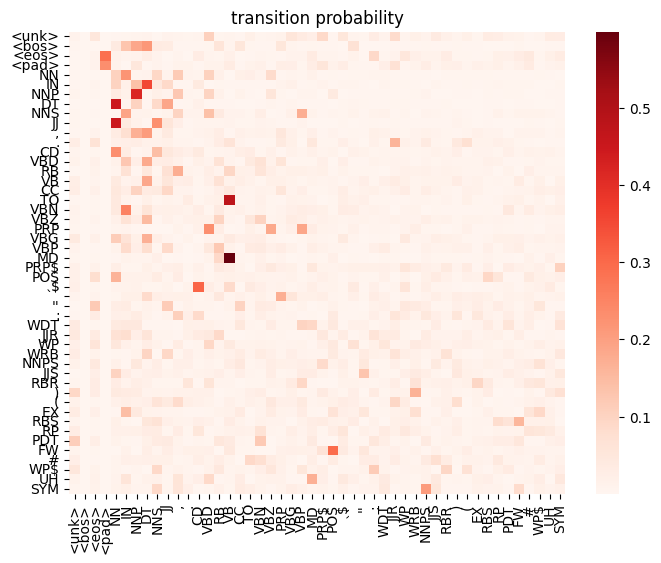

In [202]:
plt.figure(figsize=(8, 6))
plt.title('transition probability')
heatmap(
    model.head.transition
    .softmax(-1)
    .clone()
    .detach()
    .cpu()
    .numpy(),
    xticklabels=label_vocab.get_itos(),
    yticklabels=label_vocab.get_itos(),
    cmap="Reds",
)